# Neural Network from scratch

This project is a neural network built entirely from scratch using only NumPy, without relying on high-level libraries like Keras or TensorFlow. The model is trained on the MNIST image dataset, which contains 42,000 training images and 28,000 test images of handwritten digits (0-9).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

In [2]:
# Load and preprocess data
train_data = pd.read_csv("digit-recognizer/train.csv")
test_data = pd.read_csv("digit-recognizer/test.csv")

In [3]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Separate features and labels
X_train = train_data.drop("label", axis=1).values
y_train = train_data["label"].values

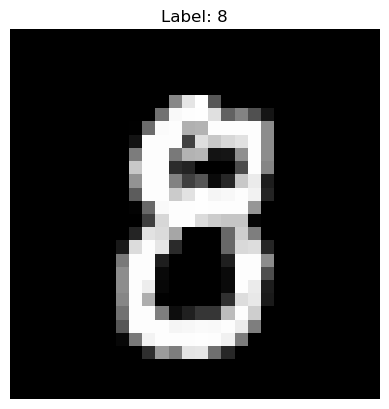

In [53]:
# Display one input image
def plot_image(image, label=None):
    image = image.reshape(28, 28)
    plt.imshow(image, cmap='gray')
    if label is not None:
        plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

plot_image(X_train[99], y_train[99])

In [7]:
# Split training data to create a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [8]:
# Normalize pixel values
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = test_data.values / 255.0

In [9]:
# One-hot encoding function
def one_hot_encode(y, num_classes=10):
    m = y.shape[0]
    y_encoded = np.zeros((m, num_classes))
    y_encoded[np.arange(m), y] = 1
    return y_encoded

y_train_encoded = one_hot_encode(y_train)
y_val_encoded = one_hot_encode(y_val)

In [10]:
# Neural network dimensions
n_x = 784  # Input layer (28x28 pixels)
n_h = 128  # Hidden layer (increased from 64)
n_y = 10   # Output layer (10 digits)

In [11]:
# weight initialization
def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(42)
    # He initialization for ReLU activation
    W1 = np.random.randn(n_h, n_x) * np.sqrt(2.0 / n_x)
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * np.sqrt(2.0 / n_h)
    b2 = np.zeros((n_y, 1))
    
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    return parameters

In [12]:
# Activation functions
def relu(Z):
    return np.maximum(0, Z)

def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

In [14]:
# Forward propagation
def forward_propagation(X, parameters):
    W1, b1, W2, b2 = parameters["W1"], parameters["b1"], parameters["W2"], parameters["b2"]
    
    Z1 = np.dot(W1, X.T) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = softmax(Z2)
    
    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
    return A2, cache

In [15]:
# Cost function with L2 regularization
def compute_cost(A2, Y, parameters, lambda_reg=0.01):
    m = Y.shape[0]
    W1, W2 = parameters["W1"], parameters["W2"]
    
    # Cross-entropy loss
    log_probs = -np.log(A2.T[range(m), np.argmax(Y, axis=1)])
    cross_entropy_cost = np.sum(log_probs) / m
    
    # L2 regularization term
    l2_cost = (lambda_reg / (2 * m)) * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    
    # Total cost
    cost = cross_entropy_cost + l2_cost
    return cost

In [16]:
# Derivative of ReLU
def relu_derivative(Z):
    return np.where(Z > 0, 1, 0)

# Backward propagation with L2 regularization
def backward_propagation(X, Y, parameters, cache, lambda_reg=0.01):
    m = X.shape[0]
    W1, W2 = parameters["W1"], parameters["W2"]
    A1, A2 = cache["A1"], cache["A2"]
    Z1 = cache["Z1"]
    
    # Output layer gradients
    dZ2 = A2 - Y.T
    dW2 = (1 / m) * np.dot(dZ2, A1.T) + (lambda_reg / m) * W2
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    
    # Hidden layer gradients
    dZ1 = np.dot(W2.T, dZ2) * relu_derivative(Z1)
    dW1 = (1 / m) * np.dot(dZ1, X) + (lambda_reg / m) * W1
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    return grads

In [17]:
# Adam optimizer implementation
def initialize_adam(parameters):
    v = {}
    s = {}
    
    for key in parameters:
        v["d" + key] = np.zeros_like(parameters[key])
        s["d" + key] = np.zeros_like(parameters[key])
    
    return v, s

In [18]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    v_corrected = {}
    s_corrected = {}
    
    for key in parameters:
        # Moving average of the gradients
        v["d" + key] = beta1 * v["d" + key] + (1 - beta1) * grads["d" + key]
        # Moving average of the squared gradients
        s["d" + key] = beta2 * s["d" + key] + (1 - beta2) * np.square(grads["d" + key])
        
        # Bias correction
        v_corrected["d" + key] = v["d" + key] / (1 - np.power(beta1, t))
        s_corrected["d" + key] = s["d" + key] / (1 - np.power(beta2, t))
        
        # Update parameters
        parameters[key] = parameters[key] - learning_rate * v_corrected["d" + key] / (np.sqrt(s_corrected["d" + key]) + epsilon)
    
    return parameters, v, s

In [19]:
# Function to compute prediction accuracy
def compute_accuracy(predictions, labels):
    if labels.ndim > 1:  # If labels are one-hot encoded
        labels = np.argmax(labels, axis=1)
    return np.mean(predictions == labels) * 100

In [20]:
# Mini-batch generation function
def random_mini_batches(X, Y, mini_batch_size=64):
    m = X.shape[0]
    mini_batches = []
    
    # Shuffle the data
    permutation = np.random.permutation(m)
    shuffled_X = X[permutation]
    shuffled_Y = Y[permutation]
    
    # Create mini-batches
    num_complete_minibatches = m // mini_batch_size
    
    for k in range(num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size:(k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[k * mini_batch_size:(k + 1) * mini_batch_size]
        mini_batches.append((mini_batch_X, mini_batch_Y))
    
    # Handle the remaining examples if m is not divisible by mini_batch_size
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size:]
        mini_batches.append((mini_batch_X, mini_batch_Y))
    
    return mini_batches

In [21]:
# Prediction function for test data
def predict(X, parameters):
    A2, _ = forward_propagation(X, parameters)
    predictions = np.argmax(A2, axis=0)
    return predictions

In [22]:
# Feature engineering function - adds some additional features to improve accuracy
def add_features(X):
    # Calculate average pixel intensity for each image
    avg_intensity = np.mean(X, axis=1, keepdims=True)
    
    # Calculate standard deviation of pixel intensities
    std_intensity = np.std(X, axis=1, keepdims=True)
    
    # Reshape to 28x28 to extract more features
    X_img = X.reshape(-1, 28, 28)
    
    # Calculate horizontal and vertical symmetry (useful for digits like 0, 8)
    h_symmetry = np.mean(np.abs(X_img - X_img[:, :, ::-1]), axis=(1, 2)).reshape(-1, 1)
    v_symmetry = np.mean(np.abs(X_img - X_img[:, ::-1, :]), axis=(1, 2)).reshape(-1, 1)
    
    # Combine all features
    X_enhanced = np.hstack((X, avg_intensity, std_intensity, h_symmetry, v_symmetry))
    
    return X_enhanced

In [23]:
# Apply feature engineering
X_train_enhanced = add_features(X_train)
X_val_enhanced = add_features(X_val)
X_test_enhanced = add_features(X_test)

In [24]:
# Updated input size with additional features
n_x = X_train_enhanced.shape[1]

In [25]:
# Main model function with mini-batch and Adam optimizer
def improved_model(X_train, Y_train, X_val, Y_val, n_x, n_h, n_y, num_epochs=30, 
                  mini_batch_size=128, learning_rate=0.001, lambda_reg=0.01, 
                  print_interval=1):
    
    print(f"Starting training with {n_h} hidden units, {learning_rate} learning rate...")
    start_time = time.time()
    
    # Initialize parameters
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Initialize Adam optimizer parameters
    v, s = initialize_adam(parameters)
    t = 0
    
    # Lists to store metrics
    train_costs = []
    train_accuracies = []
    val_accuracies = []
    
    # Early stopping variables
    best_val_accuracy = 0
    patience = 5
    patience_counter = 0
    best_parameters = parameters.copy()
    
    for epoch in range(num_epochs):
        epoch_cost = 0
        epoch_accuracy = 0
        num_batches = 0
        
        # Generate mini-batches
        mini_batches = random_mini_batches(X_train, Y_train, mini_batch_size)
        
        for mini_batch in mini_batches:
            mini_batch_X, mini_batch_Y = mini_batch
            
            # Forward propagation
            A2, cache = forward_propagation(mini_batch_X, parameters)
            
            # Compute cost
            cost = compute_cost(A2, mini_batch_Y, parameters, lambda_reg)
            
            # Backward propagation
            grads = backward_propagation(mini_batch_X, mini_batch_Y, parameters, cache, lambda_reg)
            
            # Update parameters with Adam optimizer
            t += 1
            parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate)
            
            # Calculate batch accuracy
            mini_batch_predictions = np.argmax(A2, axis=0)
            mini_batch_true_labels = np.argmax(mini_batch_Y, axis=1)
            batch_accuracy = compute_accuracy(mini_batch_predictions, mini_batch_true_labels)
            
            # Accumulate metrics
            epoch_cost += cost
            epoch_accuracy += batch_accuracy
            num_batches += 1
        
        # Calculate average metrics for the epoch
        epoch_cost /= num_batches
        epoch_accuracy /= num_batches
        
        # Evaluate on validation set
        val_A2, _ = forward_propagation(X_val, parameters)
        val_predictions = np.argmax(val_A2, axis=0)
        val_true_labels = np.argmax(Y_val, axis=1)
        val_accuracy = compute_accuracy(val_predictions, val_true_labels)
        
        # Store metrics
        train_costs.append(epoch_cost)
        train_accuracies.append(epoch_accuracy)
        val_accuracies.append(val_accuracy)
        
        # Early stopping check
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_parameters = parameters.copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Print progress
        if epoch % print_interval == 0:
            print(f"Epoch {epoch}, Cost: {epoch_cost:.4f}, Train Acc: {epoch_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")
        
        # Early stopping
        if patience_counter >= patience and val_accuracy > 95:
            print(f"Early stopping at epoch {epoch} with validation accuracy: {val_accuracy:.2f}%")
            break
        
        # Adjust learning rate (learning rate decay)
        if (epoch + 1) % 10 == 0:
            learning_rate *= 0.9
            print(f"Learning rate adjusted to {learning_rate:.6f}")
    
    end_time = time.time()
    print(f"Training completed in {end_time - start_time:.2f} seconds")
    print(f"Best validation accuracy: {best_val_accuracy:.2f}%")
    
    # Plot training metrics
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_costs)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train')
    plt.plot(val_accuracies, label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()
    
    return best_parameters


Starting optimized MNIST training...
Starting training with 128 hidden units, 0.001 learning rate...
Epoch 0, Cost: 0.4377, Train Acc: 88.49%, Val Acc: 93.14%
Epoch 1, Cost: 0.2087, Train Acc: 94.43%, Val Acc: 94.81%
Epoch 2, Cost: 0.1583, Train Acc: 95.94%, Val Acc: 95.62%
Epoch 3, Cost: 0.1282, Train Acc: 96.80%, Val Acc: 96.31%
Epoch 4, Cost: 0.1083, Train Acc: 97.39%, Val Acc: 96.62%
Epoch 5, Cost: 0.0946, Train Acc: 97.84%, Val Acc: 96.48%
Epoch 6, Cost: 0.0825, Train Acc: 98.26%, Val Acc: 96.83%
Epoch 7, Cost: 0.0743, Train Acc: 98.50%, Val Acc: 97.17%
Epoch 8, Cost: 0.0679, Train Acc: 98.73%, Val Acc: 97.24%
Epoch 9, Cost: 0.0625, Train Acc: 98.84%, Val Acc: 97.17%
Learning rate adjusted to 0.000900
Epoch 10, Cost: 0.0566, Train Acc: 99.07%, Val Acc: 97.48%
Epoch 11, Cost: 0.0523, Train Acc: 99.29%, Val Acc: 97.57%
Epoch 12, Cost: 0.0501, Train Acc: 99.37%, Val Acc: 97.38%
Epoch 13, Cost: 0.0478, Train Acc: 99.44%, Val Acc: 97.64%
Epoch 14, Cost: 0.0450, Train Acc: 99.54%, Val A

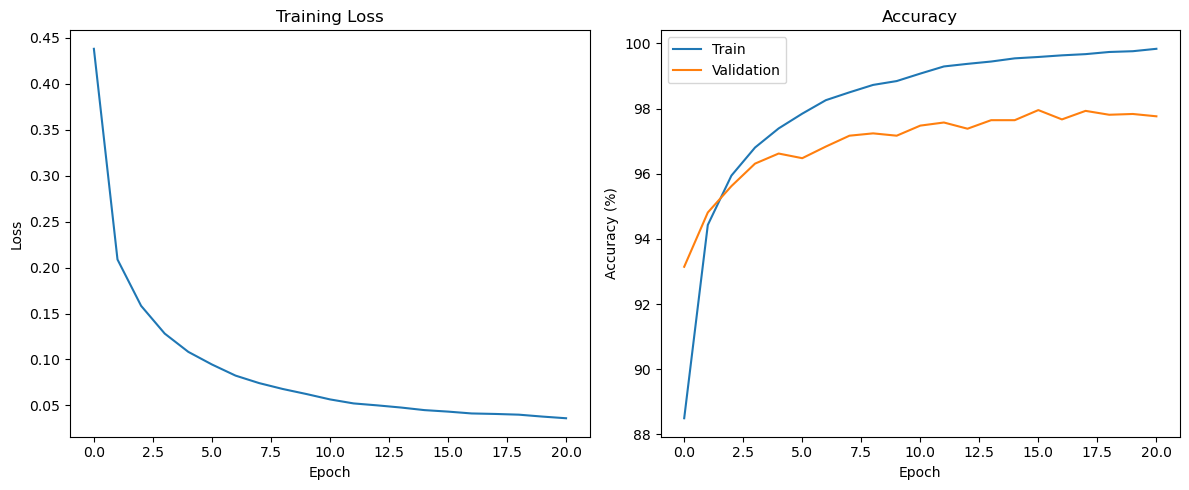

In [26]:
# Train the model
print("Starting optimized MNIST training...")
parameters = improved_model(X_train_enhanced, y_train_encoded, X_val_enhanced, y_val_encoded, 
                          n_x, n_h, n_y, num_epochs=30, learning_rate=0.001)


In [30]:
# Make predictions on test data
predictions = predict(X_test_enhanced, parameters)

# Print sample predictions
print("Predictions on the first 10 test samples:", predictions[:10])

Predictions on the first 10 test samples: [2 0 9 9 3 7 0 3 0 3]


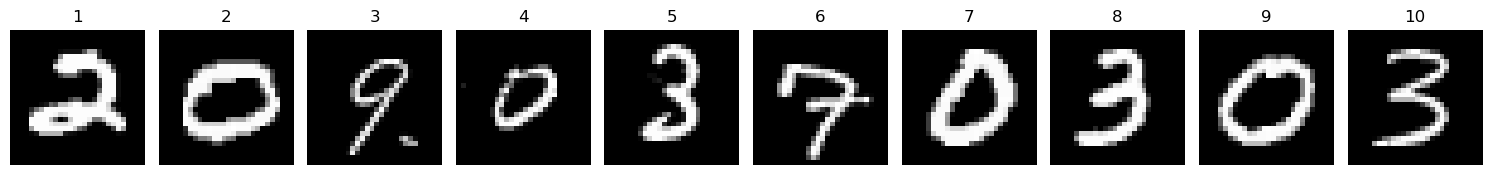

In [32]:
def print_test_samples(X_test, num_samples=10):
    plt.figure(figsize=(15, 3))  # Increased figure size for better spacing
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(X_test[i].reshape(28, 28), cmap="gray")
        plt.title(f"{i+1}", fontsize=12)  # Display the sample number as title
        plt.axis("off")
    plt.tight_layout(pad=1.0)  # Add padding between subplots
    plt.show()

# Call the function to print the first 10 test samples
print_test_samples(X_test, num_samples=10)

Loading image from myhandwritten3.jpg...


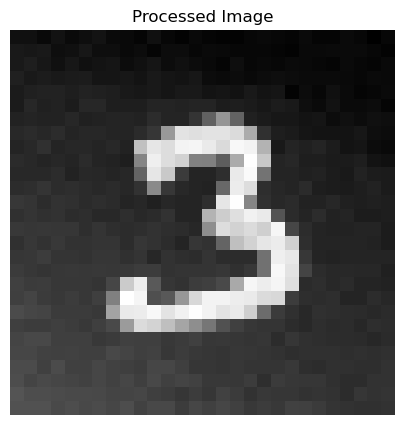

Prediction: 3
Confidence scores:
Digit 0: 0.00%
Digit 1: 0.00%
Digit 2: 5.11%
Digit 3: 91.85%
Digit 4: 0.00%
Digit 5: 0.60%
Digit 6: 0.00%
Digit 7: 0.00%
Digit 8: 2.42%
Digit 9: 0.01%

Top 3 predictions:
1. Digit 3: 91.85%
2. Digit 2: 5.11%
3. Digit 8: 2.42%


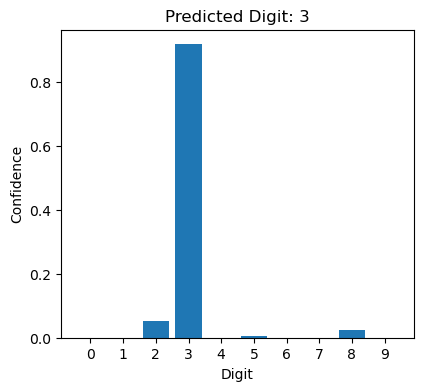

In [ ]:
from PIL import Image
import cv2

def predict_handwritten_digit(image_path, parameters):
    # Load the image
    print(f"Loading image from {image_path}...")
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Preprocessing steps
    # 1. Resize to 28x28 (MNIST size)
    img = cv2.resize(img, (28, 28))
    
    # 2. Invert if needed (MNIST has white digits on black background)
    if np.mean(img) > 127:
        # Image has a white background and black digit, invert it
        img = 255 - img  
    
    # 3. Normalize pixel values to [0, 1] range
    img_normalized = img.astype(np.float32) / 255.0
    
    # 4. Flatten the image to match model input shape (1, 784)
    img_vector = img_normalized.flatten().reshape(1, 784)
    
    # Add engineered features (same as in training)
    img_enhanced = add_features(img_vector)
    
    # Display the processed image to verify correctness
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray')
    plt.title("Processed Image")
    plt.axis('off')
    plt.show()
    
    # Make prediction
    A2, _ = forward_propagation(img_enhanced, parameters)
    prediction = np.argmax(A2, axis=0)[0]
    
    # Get confidence scores for all digits
    confidence_scores = A2.T[0]
    
    # Display the result with confidence scores
    print(f"Prediction: {prediction}")
    print("Confidence scores:")
    for digit in range(10):
        print(f"Digit {digit}: {confidence_scores[digit]*100:.2f}%")
    
    # Show the prediction in a nice visual format
    plt.figure(figsize=(10, 4))
    
    # Plot the confidence scores
    plt.subplot(1, 2, 1)
    plt.bar(range(10), confidence_scores)
    plt.xticks(range(10))
    plt.xlabel('Digit')
    plt.ylabel('Confidence')
    plt.title(f'Predicted Digit: {prediction}')
    
    # Highlight the top 3 predictions
    top_indices = np.argsort(confidence_scores)[-3:][::-1]
    print("\nTop 3 predictions:")
    for i, idx in enumerate(top_indices):
        print(f"{i+1}. Digit {idx}: {confidence_scores[idx]*100:.2f}%")
    
    return prediction

# Example usage - after training your model:
image_path = 'myhandwritten3.jpg'  # Update this path to your image file
predicted_digit = predict_handwritten_digit(image_path, parameters)